# Logging particles undergoing transition
It is often useful to be able to track the particles belonging to the dected detections.
Loging was created for this purpose. In this example we showcase how to use the loging
infrastructure to figure out the particles undergoing the transition.

In [38]:

# Initialize the simulation
import numpy as np
import math

import fresnel
import IPython

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)


def render(snapshot):
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry_B = fresnel.geometry.Sphere(
        scene, N=np.sum(snapshot.particles.typeid == 1), radius=0.5
    )
    geometry_B.material = fresnel.material.Material(
        color=fresnel.color.linear([1 / 255, 109 / 255, 1 / 255]), roughness=0.5
    )
    geometry = fresnel.geometry.Sphere(
        scene, N=np.sum(snapshot.particles.typeid == 0), radius=0.125
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]),
        roughness=5,
        metal=0,
        specular=0.95,
        spec_trans=0.95,
    )
    geometry.position[:] = snapshot.particles.position[
        snapshot.particles.typeid == 0, :
    ]
    geometry.outline_width = 0.04
    geometry_B.position[:] = snapshot.particles.position[
        snapshot.particles.typeid == 1, :
    ]
    geometry_B.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())


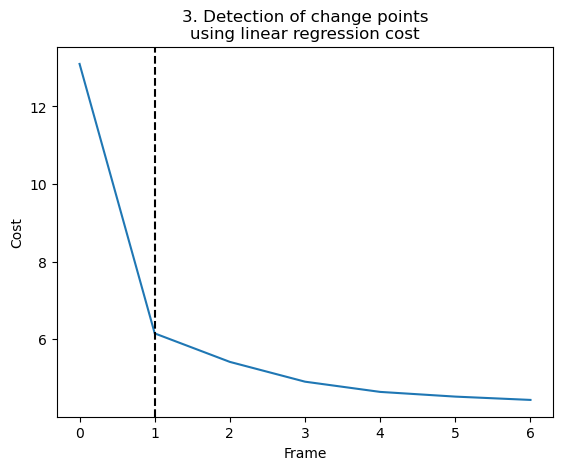

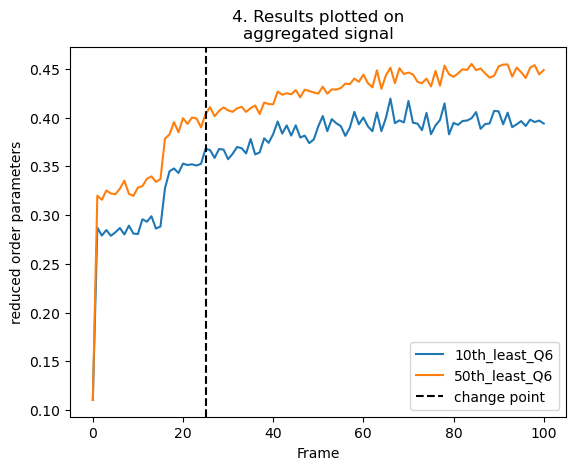

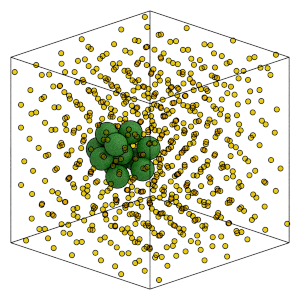

In [37]:
import copy
import dupin as du
import freud
import gsd.hoomd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt

ls=6
FILENAME = "../data/lj-sim.gsd"
steinhardt = freud.order.Steinhardt(l=ls)
nlist_kwargs = {"num_neighbors": 12, "exclude_ii": True}
logger = du.data.logging.Logger()

pipeline = du.data.freud.FreudDescriptor(
    compute=steinhardt, attrs = {"particle_order":f"Q{ls}"}
).pipe(du.data.reduce.NthGreatest((-10, -50)))
signal_aggregator = du.data.aggregate.SignalAggregator(pipeline,logger)
with gsd.hoomd.open(FILENAME, "r") as traj:
    for frame in traj:
        signal_aggregator.accumulate(frame,nlist_kwargs)
lin_regress_cost = du.detect.CostLinearFit()
dynp = rpt.Dynp(custom_cost=lin_regress_cost)
sweep_detector = du.detect.SweepDetector(dynp, max_change_points=6,tolerance=0.001)
change_points = sweep_detector.fit(signal_aggregator.to_dataframe())
change_point_particle_id = logger.frames[change_points[0]]["Q6"]["NthGreatest"]["10th_least"]
plt.plot(sweep_detector.costs_)
plt.title("3. Detection of change points\nusing linear regression cost")
plt.xlabel("Frame")
plt.ylabel("Cost")
plt.axvline(sweep_detector.opt_n_change_points_, color='k', linestyle="--")
plt.show()
# add change points as vlines
plt.plot(signal_aggregator.to_dataframe().to_numpy(),label=signal_aggregator.to_dataframe().columns.to_list())
for change_point in change_points:
    plt.axvline(change_point, color='k', linestyle='--',label='change point')
plt.title("4. Results plotted on\naggregated signal")
plt.xlabel("Frame")
plt.ylabel("reduced order parameters")
plt.legend()
plt.show()
with gsd.hoomd.open(FILENAME, "r") as f:
    frame:gsd.hoomd.Frame = f[change_points[0]]
    aabbq = freud.locality.AABBQuery(frame.configuration.box, frame.particles.position)
    neighbor_list = aabbq.query([frame.particles.position[change_point_particle_id]], nlist_kwargs).toNeighborList()
    ids = neighbor_list.point_indices
    particle_ids = copy.deepcopy(frame.particles.typeid)
    particle_ids[ids] = 1
    newframe = gsd.hoomd.Frame()
    newframe.configuration.box = frame.configuration.box
    newframe.particles.position = frame.particles.position
    newframe.particles.types = frame.particles.types
    newframe.particles.typeid = particle_ids
    img = render(newframe)
    display(img)